In [1]:
!pip install -U sentence-transformers

In [2]:
from sentence_transformers import SentenceTransformer, util

# Load once globally
embedding_model = SentenceTransformer("all-MiniLM-L6-v2") 

2025-05-22 14:54:54.318903: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import json
import re
import openai
import json5
import pandas as pd
import numpy as np
import random
import sys
import os
sys.path.append(os.path.abspath(".."))
import matplotlib.pyplot as plt
import networkx as nx

In [4]:
import importlib
import src.graph_builder
import src.graph_queries
import src.prompt_to_rules
import src.semantic_matcher
importlib.reload(src.graph_queries)
importlib.reload(src.prompt_to_rules)
importlib.reload(src.semantic_matcher)

<module 'src.semantic_matcher' from '/home/sagemaker-user/auto-audience-generator/src/semantic_matcher.py'>

In [5]:
from src.graph_builder import build_knowledge_graph_from_config
from src.graph_queries import apply_persona_to_graph
from src.graph_queries import apply_logical_rule
from src.prompt_to_rules import extract_rules_from_prompt_llm2
from src.prompt_to_rules import extract_rules_from_prompt_llm3
from src.semantic_matcher import SemanticMatcher

In [6]:
# Set seed for reproducibility
np.random.seed(42)

# Generate Users Dataset
user_ids = [f"user_{i}" for i in range(100)]
ages = np.random.randint(18, 70, size=100)
genders = np.random.choice(['Male', 'Female', 'Other'], size=100)
locations = np.random.choice(['California', 'New York', 'Texas', 'Florida', 'Illinois'], size=100)
education_levels = np.random.choice(['High School', 'Bachelor', 'Master', 'PhD', 'College Senior'], size=100)

users_df = pd.DataFrame({
    'user_id': user_ids,
    'age': ages,
    'gender': genders,
    'location': locations,
    'education_level': education_levels
})
users_df.to_csv("../data/users.csv", index=False)

# Generate Products Dataset
product_ids = [f"prod_{i}" for i in range(100)]
categories = np.random.choice(['Electronics', 'Books', 'Fitness', 'Crypto', 'Gaming'], size=100)
tags = np.random.choice(['blockchain', 'sports', 'AI', 'yoga', 'finance'], size=100)

products_df = pd.DataFrame({
    'product_id': product_ids,
    'category': categories,
    'tag': tags
})
products_df.to_csv("../data/products.csv", index=False)

# Generate Orders Dataset
orders = []
for _ in range(200):
    orders.append({
        'user_id': random.choice(user_ids),
        'order_id': f"order_{random.randint(1, 1000)}",
        'product_id': random.choice(product_ids),
        'order_date': pd.Timestamp('2024-01-01') + pd.to_timedelta(random.randint(0, 100), unit='d')
    })
orders_df = pd.DataFrame(orders)
orders_df.to_csv("../data/orders.csv", index=False)

# Generate Streaming Dataset
content_names = [f"content_{i}" for i in range(100)]
genres = np.random.choice(['sports', 'technology', 'crypto', 'fitness', 'news'], size=100)
streaming = []
for _ in range(200):
    streaming.append({
        'user_id': random.choice(user_ids),
        'content_name': random.choice(content_names),
        'timestamp': pd.Timestamp('2024-01-01') + pd.to_timedelta(random.randint(0, 100), unit='d'),
        'genre': random.choice(genres),
        'watch_duration': random.randint(5, 120)
    })
streaming_df = pd.DataFrame(streaming)
streaming_df.to_csv("../data/streaming.csv", index=False)


In [7]:
G = build_knowledge_graph_from_config(
    "../config/graph_schema.json",
    {
        "users": "../data/users.csv",
        "products": "../data/products.csv",
        "orders": "../data/orders.csv",
        "streaming": "../data/streaming.csv"
    }
)

✅ Graph successfully created
Number of nodes: 300
Number of edges: 661


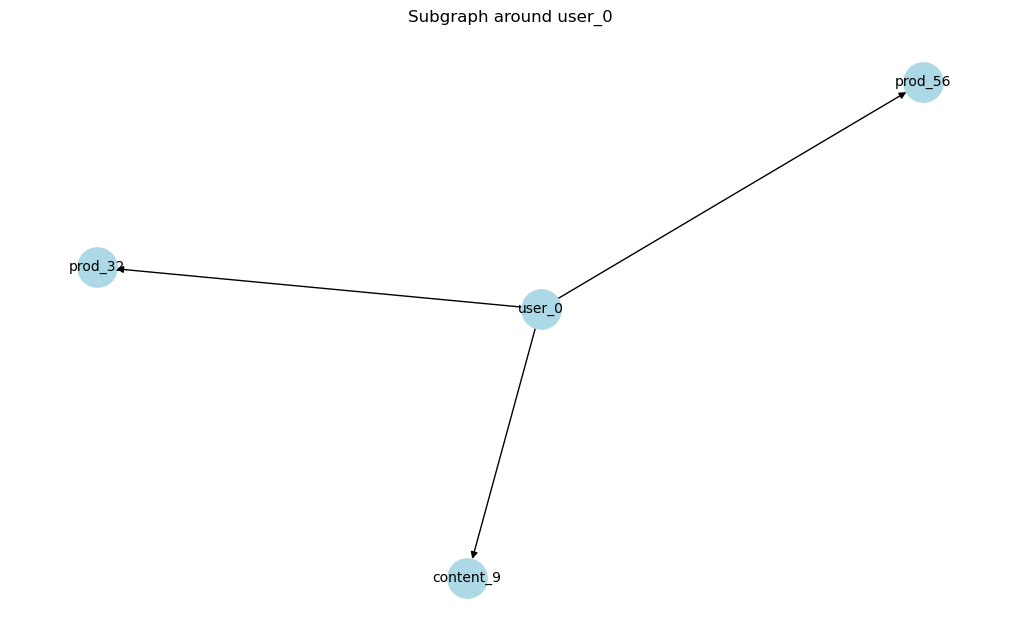

In [8]:
sub_nodes = list(G.successors('user_0')) + ['user_0']
subgraph = G.subgraph(sub_nodes)

plt.figure(figsize=(10, 6))
nx.draw(subgraph, with_labels=True, node_size=800, node_color='lightblue', font_size=10)
plt.title("Subgraph around user_0")
plt.show()

In [9]:
prompt = "Find crypto enthusiasts"
rules = extract_rules_from_prompt_llm2(prompt)
print("Extracted Persona Rule:", rules)

audience = apply_persona_to_graph(G, rules["persona"])
print("Final Audience:", audience)

Extracted Persona Rule: {'persona': {'tag': ['blockchain', 'cryptocurrency'], 'genre': ['technology', 'finance']}}
Final Audience: {'user_63', 'user_22', 'user_89', 'user_14', 'user_39', 'user_27', 'user_70', 'user_26', 'user_2', 'user_77', 'user_36', 'user_92', 'user_43', 'user_61', 'user_25', 'user_86', 'user_23', 'user_51', 'user_7', 'user_55', 'user_1', 'user_93', 'user_21', 'user_10', 'user_13', 'user_24', 'user_31', 'user_71', 'user_62'}


In [10]:
prompt = "Find users interested in investing"
rules = extract_rules_from_prompt_llm2(prompt)
print("Extracted Persona Rule:", rules)

audience = apply_persona_to_graph(G, rules["persona"])
print("Final Audience:", audience)

Extracted Persona Rule: {'persona': {'tag': ['investing'], 'genre': ['finance', 'business']}}
Final Audience: {'user_87', 'user_22', 'user_59', 'user_69', 'user_14', 'user_84', 'user_91', 'user_27', 'user_48', 'user_26', 'user_2', 'user_47', 'user_96', 'user_28', 'user_73', 'user_77', 'user_36', 'user_82', 'user_66', 'user_95', 'user_43', 'user_61', 'user_64', 'user_11', 'user_25', 'user_23', 'user_86', 'user_44', 'user_90', 'user_20', 'user_7', 'user_1', 'user_97', 'user_52', 'user_76', 'user_58', 'user_45', 'user_18', 'user_57', 'user_74', 'user_88', 'user_32', 'user_78', 'user_21', 'user_10', 'user_24', 'user_31', 'user_75'}


In [11]:
prompt = "Find users interested in education"
rules = extract_rules_from_prompt_llm2(prompt)
print("Extracted Persona Rule:", rules)

audience = apply_persona_to_graph(G, rules["persona"])
print("Final Audience:", audience)

Extracted Persona Rule: {'persona': {'education_level': 'High School Junior, High School Senior, College Freshman, College Sophomore, College Junior, College Senior', 'tag': ['education'], 'genre': ['education', 'career']}}
Final Audience: set()


In [12]:
prompt = "Find users about to graduate"
rules = extract_rules_from_prompt_llm2(prompt)
print("Extracted Persona Rule:", rules)

audience = apply_persona_to_graph(G, rules["persona"])
print("Final Audience:", audience)

Extracted Persona Rule: {'persona': {'age': {'operator': '>=', 'value': 21}, 'education_level': 'College Senior', 'tag': ['job prep', 'career'], 'genre': ['technology', 'education']}}
Final Audience: {'user_63', 'user_69', 'user_80', 'user_89', 'user_39', 'user_99', 'user_19', 'user_27', 'user_30', 'user_68', 'user_48', 'user_0', 'user_16', 'user_26', 'user_70', 'user_72', 'user_83', 'user_73', 'user_9', 'user_82', 'user_54', 'user_92', 'user_3', 'user_61', 'user_64', 'user_25', 'user_23', 'user_51', 'user_90', 'user_4', 'user_50', 'user_20', 'user_7', 'user_55', 'user_1', 'user_40', 'user_97', 'user_52', 'user_76', 'user_8', 'user_29', 'user_93', 'user_18', 'user_57', 'user_74', 'user_88', 'user_78', 'user_21', 'user_10', 'user_13', 'user_79', 'user_31', 'user_56', 'user_71', 'user_62'}


In [ ]:
matcher = SemanticMatcher(G)

In [21]:
expanded = matcher.expand("finance", verbose=True )
print("Expanded:", expanded)

expanded = matcher.expand("crypto", verbose=True )
print("Expanded:", expanded)


🔍 Semantic matches for: 'finance' (threshold=0.4)
→ finance (score: 1.000)
→ blockchain (score: 0.447)
→ crypto (score: 0.412)
→ technology (score: 0.402)
Expanded: ['finance', 'blockchain', 'crypto', 'technology']

🔍 Semantic matches for: 'crypto' (threshold=0.4)
→ crypto (score: 1.000)
→ blockchain (score: 0.576)
→ finance (score: 0.412)
Expanded: ['crypto', 'blockchain', 'finance']


In [16]:
query = "crypto"
query_embedding = matcher.model.encode(query, convert_to_tensor=True)
scores = util.cos_sim(query_embedding, matcher.kg_embeddings)[0]

scored_terms = list(zip(matcher.kg_terms, scores.tolist()))
scored_terms.sort(key=lambda x: x[1], reverse=True)

for term, score in scored_terms[:10]:
    print(f"{term:20s} → score: {score:.3f}")

crypto               → score: 1.000
blockchain           → score: 0.576
finance              → score: 0.412
technology           → score: 0.336
ai                   → score: 0.300
news                 → score: 0.249
sports               → score: 0.240
fitness              → score: 0.186
yoga                 → score: 0.174


In [22]:
rules_obj = extract_rules_from_prompt_llm3("Find crypto enthusiasts")

print("Extracted Rules:", rules_obj)

for rule in rules_obj.get("rules", []):
    print(f"\n🔍 Audience: {rule['name']}")
    audience = apply_logical_rule(G, rule, matcher=matcher)
    print(f"🎯 Users: {audience}")

Extracted Rules: {'rules': [{'name': 'Crypto Enthusiasts', 'conditions': {'or': [{'field': 'tag', 'in': ['crypto']}, {'field': 'genre', 'in': ['blockchain']}]}}]}

🔍 Audience: Crypto Enthusiasts
🎯 Users: {'user_69', 'user_84', 'user_19', 'user_46', 'user_35', 'user_60', 'user_96', 'user_73', 'user_38', 'user_6', 'user_33', 'user_95', 'user_43', 'user_64', 'user_23', 'user_4', 'user_50', 'user_20', 'user_8', 'user_45', 'user_93', 'user_88', 'user_21', 'user_79', 'user_75', 'user_67', 'user_89', 'user_99', 'user_27', 'user_30', 'user_16', 'user_5', 'user_49', 'user_15', 'user_47', 'user_54', 'user_17', 'user_86', 'user_44', 'user_97', 'user_76', 'user_12', 'user_18', 'user_57', 'user_32', 'user_24', 'user_71', 'user_63', 'user_80', 'user_39', 'user_91', 'user_48', 'user_0', 'user_26', 'user_72', 'user_83', 'user_9', 'user_66', 'user_81', 'user_90', 'user_55', 'user_1', 'user_94', 'user_52', 'user_29', 'user_58', 'user_78', 'user_10', 'user_56', 'user_62', 'user_87', 'user_22', 'user_59',

In [23]:
rules_obj = extract_rules_from_prompt_llm3("Find crypto enthusiasts")

print("Extracted Rules:", rules_obj)

for rule in rules_obj.get("rules", []):
    print(f"\n🔍 Audience: {rule['name']}")
    audience = apply_logical_rule(G, rule, matcher=matcher)
    print(f"🎯 Users: {audience}")

Extracted Rules: {'rules': [{'name': 'Crypto Enthusiasts', 'conditions': {'or': [{'field': 'tag', 'in': ['crypto']}, {'field': 'genre', 'in': ['finance', 'tech', 'cryptocurrency']}]}}]}

🔍 Audience: Crypto Enthusiasts
🎯 Users: {'user_69', 'user_84', 'user_19', 'user_46', 'user_35', 'user_60', 'user_96', 'user_73', 'user_38', 'user_6', 'user_33', 'user_95', 'user_43', 'user_64', 'user_23', 'user_4', 'user_50', 'user_20', 'user_53', 'user_8', 'user_34', 'user_45', 'user_93', 'user_88', 'user_21', 'user_79', 'user_75', 'user_67', 'user_89', 'user_99', 'user_27', 'user_30', 'user_16', 'user_5', 'user_49', 'user_15', 'user_47', 'user_98', 'user_54', 'user_17', 'user_86', 'user_44', 'user_97', 'user_76', 'user_12', 'user_18', 'user_57', 'user_32', 'user_24', 'user_71', 'user_63', 'user_80', 'user_39', 'user_91', 'user_48', 'user_0', 'user_26', 'user_72', 'user_83', 'user_9', 'user_66', 'user_81', 'user_90', 'user_55', 'user_1', 'user_94', 'user_52', 'user_29', 'user_58', 'user_78', 'user_10'

In [24]:
rules_obj = extract_rules_from_prompt_llm3("Find crypto enthusiasts")

print("Extracted Rules:", rules_obj)

for rule in rules_obj.get("rules", []):
    print(f"\n🔍 Audience: {rule['name']}")
    audience = apply_logical_rule(G, rule, matcher=matcher)
    print(f"🎯 Users: {audience}")

Extracted Rules: {'rules': [{'name': 'Crypto Enthusiasts', 'conditions': {'or': [{'field': 'tag', 'in': ['crypto']}, {'field': 'genre', 'in': ['crypto', 'blockchain']}]}}]}

🔍 Audience: Crypto Enthusiasts
🎯 Users: {'user_69', 'user_84', 'user_19', 'user_46', 'user_35', 'user_60', 'user_96', 'user_73', 'user_38', 'user_6', 'user_33', 'user_95', 'user_43', 'user_64', 'user_23', 'user_4', 'user_50', 'user_20', 'user_8', 'user_45', 'user_93', 'user_88', 'user_21', 'user_79', 'user_75', 'user_67', 'user_89', 'user_99', 'user_27', 'user_30', 'user_16', 'user_5', 'user_49', 'user_15', 'user_47', 'user_54', 'user_17', 'user_86', 'user_44', 'user_97', 'user_76', 'user_12', 'user_18', 'user_57', 'user_32', 'user_24', 'user_71', 'user_63', 'user_80', 'user_39', 'user_91', 'user_48', 'user_0', 'user_26', 'user_72', 'user_83', 'user_9', 'user_66', 'user_81', 'user_90', 'user_55', 'user_1', 'user_94', 'user_52', 'user_29', 'user_58', 'user_78', 'user_10', 'user_56', 'user_62', 'user_87', 'user_22', 

In [25]:
rules_obj = extract_rules_from_prompt_llm3("Find users interested in investing")

print("Extracted Rules:", rules_obj)

for rule in rules_obj.get("rules", []):
    print(f"\n🔍 Audience: {rule['name']}")
    audience = apply_logical_rule(G, rule, matcher=matcher)
    print(f"🎯 Users: {audience}")

Extracted Rules: {'rules': [{'name': 'Investors', 'conditions': {'and': [{'field': 'age', 'operator': '>', 'value': 18}, {'or': [{'field': 'tag', 'in': ['investing', 'stocks', 'bonds']}, {'field': 'genre', 'in': ['finance', 'business']}]}]}}, {'name': 'Young Investors', 'conditions': {'and': [{'field': 'age', 'operator': 'between', 'value': [18, 30]}, {'or': [{'field': 'tag', 'in': ['investing', 'stocks', 'bonds']}, {'field': 'genre', 'in': ['finance', 'business']}]}]}}, {'name': 'Female Investors', 'conditions': {'and': [{'field': 'gender', 'operator': '=', 'value': 'female'}, {'or': [{'field': 'tag', 'in': ['investing', 'stocks', 'bonds']}, {'field': 'genre', 'in': ['finance', 'business']}]}]}}]}

🔍 Audience: Investors
🎯 Users: set()

🔍 Audience: Young Investors
🎯 Users: set()

🔍 Audience: Female Investors
🎯 Users: set()


In [26]:
rules_obj = extract_rules_from_prompt_llm3("Find users who are about to retire")

print("Extracted Rules:", rules_obj)

for rule in rules_obj.get("rules", []):
    print(f"\n🔍 Audience: {rule['name']}")
    audience = apply_logical_rule(G, rule, matcher=matcher)
    print(f"🎯 Users: {audience}")

Extracted Rules: {'rules': [{'name': 'Users nearing retirement', 'conditions': {'and': [{'field': 'age', 'operator': '>=', 'value': 55}, {'field': 'age', 'operator': '<', 'value': 70}]}}]}

🔍 Audience: Users nearing retirement
🎯 Users: set()


In [27]:
rules_obj = extract_rules_from_prompt_llm3("Find users who are about to retire. Don't limit only on age as criteria")

print("Extracted Rules:", rules_obj)

for rule in rules_obj.get("rules", []):
    print(f"\n🔍 Audience: {rule['name']}")
    audience = apply_logical_rule(G, rule, matcher=matcher)
    print(f"🎯 Users: {audience}")

Extracted Rules: {'rules': [{'name': 'Users nearing retirement', 'conditions': {'and': [{'field': 'age', 'operator': '>=', 'value': 55}, {'field': 'location', 'operator': 'in', 'value': ['USA', 'Canada', 'Europe']}]}}, {'name': 'Tech-savvy young users', 'conditions': {'and': [{'field': 'age', 'operator': '<', 'value': 30}, {'field': 'tag', 'in': ['gaming', 'mobile']}, {'field': 'gender', 'operator': 'in', 'value': ['male', 'female']}]}}, {'name': 'Interested in finance and arts', 'conditions': {'and': [{'field': 'age', 'operator': '>', 'value': 35}, {'field': 'genre', 'in': ['finance', 'investment']}, {'field': 'tag', 'in': ['painting', 'sculpture']}]}}]}

🔍 Audience: Users nearing retirement
🎯 Users: set()

🔍 Audience: Tech-savvy young users
🎯 Users: set()

🔍 Audience: Interested in finance and arts
🎯 Users: set()
